# 10x Genomics V(D)J Sequence Analysis with Immcantation Tutorial

## Overview
This tutorial is a basic walkthrough for defining B cell clonal families and building B cell lineage trees using [10x Genomics](https://www.10xgenomics.com/products/single-cell-immune-profiling) BCR sequencing data. 

Knowledge of basic command line usage is assumed. Please check out the individual documentation sites for the functions detailed in this tutorial before using them on your own data. 

* For simplicity, this tutorial will use the [Immcantation Lab Docker image](https://hub.docker.com/repository/docker/immcantation/lab) which contains Jupyter notebook and all necessary software to run this code.
  * You can install the current Docker image with `docker pull immcantation/lab:devel`
  * For some operating systems, it may be necessary to use super-user privileges (sudo), and/or to have [Docker Desktop](https://hub.docker.com/editions/community/docker-ce-desktop-windows) running before entering the previous command.
* It is also possible to install the packages being used separately (see [pRESTO](https://presto.readthedocs.io/en/stable/install.html#installation), [Change-O](https://changeo.readthedocs.io/en/stable/install.html#installation), and [Alakazam](https://alakazam.readthedocs.io/en/stable/install/)).

The primary steps of processing 10x single cell BCR data include:

* Assigning V, D, and J genes using IgBLAST
* Filtering records
* Finding thresholds for cloning (automatically or manually)
* Defining clonal groups
* Running `CreateGermlines`
* Calculating SHM frequency in the heavy chain V genes

You may also reference [this page](https://changeo.readthedocs.io/en/stable/examples/10x.html) for further examples of how to process 10x data with Immcantation. If you have any questions about this tutorial or our software, you can email us at [immcantation@googlegroups.com](mailto:immcantation@googlegroups.com).

## Getting started

The example data is already in the container (`/home/magus/data/10x_data_2subj/`). If you want to, you can download it from [example data](http://clip.med.yale.edu/immcantation/examples/10x_data_2subj.zip) and unzip it.

* It represents the Ig V(D)J sequences from CD19+ B cells isolated from PBMCs of two healthy human donors provided by 10x Genomics under a [Creative Commons Attribute license](https://creativecommons.org/licenses/by/4.0/), and processed with their [Cell Ranger pipeline](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/what-is-cell-ranger).
* You will find two files called **filtered_contig.fasta** and **filtered_contig_annotations.csv** in the unzipped directory (*10x_data_2subj* unless you rename it). They are the direct Cell Ranger output files for donor 1. We are going to use the Ig V(D)J sequences from donor 1 to show how to process V(D)J data using Immcantation.
* You will also find a file called **sc5p_v2_hs_B_1k_multi_5gex_b_Multiplex_vdj_b_all_contig_igblast_db-pass.tsv**. This file contains processed Ig V(D)J sequences for donor 2, with assigned V, D, and J genes using AssignGenes.py and MakeDb.py. In the section of "Find the distance threshold for cloning automatically", those Ig V(D)J sequences together with the sequences from donor 1, were used to calculate the nearest neighbor distances across subjects.

In [1]:
%%bash
ls ../data/10x_data_2subj

filtered_contig.fasta
filtered_contig_annotations.csv
sc5p_v2_hs_B_1k_multi_5gex_b_Multiplex_vdj_b_all_contig_igblast_db-pass.tsv


Use the command `versions report` to list the versions of the of the Immcantation tools installed in  the container:

In [2]:
%%bash
versions report

immcantation: devel
date: 2022.04.11

presto: 0.7.0
changeo: 1.2.0
alakazam: 1.2.0
shazam: 1.1.0.999
tigger: 1.0.0.999
scoper: 1.2.0.999
dowser: 0.1.0
enchantr: 0.0.0
prestor: 0.0.7
rabhit: 0.1.5
rdi: 1.0.0
igphyml: 1.1.3

airr-py: 1.3.1
airr-r: 1.3.0
blast: 2.9.0
cd-hit: 4.8.1
igblast: 1.18.0
muscle: 3.8.425
phylip: 3.697
vsearch: 2.13.6


## Assign V, D, and J genes using IgBLAST

To process 10x V(D)J data, a combination of `AssignGenes.py` and `MakeDb.py` can be used to generate a TSV file compliant with the [AIRR Community Rearrangement schema](https://immcantation.readthedocs.io/en/stable/datastandards.html) that incorporates annotation information provided by the Cell Ranger pipeline. The files of **filtered_contig.fasta** and **filtered_contig_annotations.csv**, generated by `cellranger vdj`, can be found in the *outs* directory.

Generate AIRR Rearrangement data from the 10x V(D)J FASTA files using the steps below (the `\` just indicates a new line for visual clarity):

In [3]:
%%bash
# assign V, D, and J genes using IgBLAST
AssignGenes.py igblast -s ../data/10x_data_2subj/filtered_contig.fasta -b /usr/local/share/igblast \
   --organism human --loci ig --format blast --outdir results

   START> AssignGenes
 COMMAND> igblast
 VERSION> 1.18.0
    FILE> filtered_contig.fasta
ORGANISM> human
    LOCI> ig
   NPROC> 4

PROGRESS> 12:31:01 |Done                     | 11.2 min

  PASS> 33338
OUTPUT> filtered_contig_igblast.fmt7
   END> AssignGenes



In [4]:
%%bash
# convert IgBLAST output to AIRR format
MakeDb.py igblast -i results/filtered_contig_igblast.fmt7 -s ../data/10x_data_2subj/filtered_contig.fasta \
   -r /usr/local/share/germlines/imgt/human/vdj/imgt_human_*.fasta \
   --10x ../data/10x_data_2subj/filtered_contig_annotations.csv --extended

         START> MakeDB
       COMMAND> igblast
  ALIGNER_FILE> filtered_contig_igblast.fmt7
      SEQ_FILE> filtered_contig.fasta
       ASIS_ID> False
    ASIS_CALLS> False
       PARTIAL> False
      EXTENDED> True
INFER_JUNCTION> False

PROGRESS> 12:31:02 |Done                | 0.0 min

PROGRESS> 12:31:41 |####################| 100% (33,338) 0.6 min

OUTPUT> filtered_contig_igblast_db-pass.tsv
  PASS> 21956
  FAIL> 11382
   END> MakeDb



In [5]:
%%bash
ls results

changeo
filtered_contig_igblast.fmt7
filtered_contig_igblast_db-pass.tsv
igblast
input_sample1-n200.fasta
tigger


After running these commands, you should now have **filtered_contig_igblast_db-pass.tsv** and **filtered_contig_igblast.fmt7** in your `results` directory. 

* For a full listing of what the flags mean, see the commandline usage for [AssignGenes.py igblast](https://changeo.readthedocs.io/en/stable/tools/AssignGenes.html#assigngenes-py-igblast) and [MakeDb.py igblast](https://changeo.readthedocs.io/en/stable/tools/MakeDb.html#makedb-py-igblast). You can also read our ["Using IgBLAST"](https://changeo.readthedocs.io/en/stable/examples/igblast.html) which contains both commands.
* The `--10x filtered_contig_annotations.csv` specifies the path of the contig annotations file generated by `cellranger vdj`, which can be found in the *outs* directory.

Please note that:

* **all_contig.fasta** can be exchanged for **filtered_contig.fasta**, and **all_contig_annotations.csv** can be exchanged for **filtered_contig_annotations.csv**.
* The resulting tab-delimited table overwrites the V, D and J gene assignments generated by Cell Ranger and uses those generated by [IgBLAST](https://ncbi.github.io/igblast/) or [IMGT/HighV-QUEST](https://www.imgt.org/IMGTindex/IMGTHighV-QUEST.php) instead.
* To process mouse data and/or TCR data, alter the `--organism` and `--loci` arguments to `AssignGenes.py` accordingly (e.g., `--organism mouse`, `--loci tcr`) and use the appropriate V(D)J IMGT reference database (e.g., **IMGT_Mouse_TR*.fasta**)

## Filter records

The remaining commands in this tutorial R. The next two lines of code are required to be able to use `R magic` and run `R` code in this Jupyter notebook.

In [6]:
# R for Python
import rpy2.rinterface
%load_ext rpy2.ipython

In [7]:
%%R
# load libraries
library(alakazam)
library(data.table)
library(dowser)
library(dplyr)
library(ggplot2)
library(scoper)
library(shazam)

R[write to console]: Loading required package: ggplot2

R[write to console]: As of v1.0.0 the AIRR Rearrangement schema is now the default file format.
A description of the standard is available at https://docs.airr-community.org.
The legacy Change-O format is supported through arguments to each function
that allow the input column names to be explicitly defined.

R[write to console]: data.table 1.14.2 using 2 threads (see ?getDTthreads).  Latest news: r-datatable.com

R[write to console]: Registered S3 method overwritten by 'ggtree':
  method      from 
  identify.gg ggfun

R[write to console]: 
Attaching package: ‘dowser’


R[write to console]: The following object is masked from ‘package:alakazam’:

    ExampleDbChangeo


R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:data.table’:

    between, first, last


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to

### Removing non-productive sequences

You may wish to subset your data to only productive sequences:

In [8]:
%%R
# read in the data
data <- readChangeoDb('results/filtered_contig_igblast_db-pass.tsv')
data <- data %>% filter(productive)

cat(paste("There are", nrow(data), "rows in the data.\n"))
data %>% slice_sample(n = 5) # random examples

There are 20164 rows in the data.
# A tibble: 5 × 57
  sequence_id sequence rev_comp productive v_call d_call j_call sequence_alignm…
  <chr>       <chr>    <lgl>    <lgl>      <chr>  <chr>  <chr>  <chr>           
1 ACCCACTGTC… TGGGGAT… FALSE    TRUE       IGHV4… IGHD3… IGHJ4… CAACTGCAGCTGCAG…
2 CGATCGGGTC… GGATCAC… FALSE    TRUE       IGHV7… IGHD6… IGHJ4… CAGGTGCAGCTGGTG…
3 TGAGGGATCG… TGGGGAG… FALSE    TRUE       IGHV2… IGHD2… IGHJ4… CAGATCACCTTGAAG…
4 CCGGGATCAA… GAGCACA… FALSE    TRUE       IGLV7… <NA>   IGLJ3… CAGGCTGTGGTGACT…
5 GTACGTAAGT… GACCTGC… FALSE    TRUE       IGLV4… <NA>   IGLJ2… CAGCTTGTGCTAACT…
# … with 49 more variables: germline_alignment <chr>, junction <chr>,
#   junction_aa <chr>, v_cigar <chr>, d_cigar <chr>, j_cigar <chr>,
#   stop_codon <lgl>, vj_in_frame <lgl>, locus <chr>, junction_length <dbl>,
#   np1_length <dbl>, np2_length <dbl>, v_sequence_start <dbl>,
#   v_sequence_end <dbl>, v_germline_start <dbl>, v_germline_end <dbl>,
#   d_sequence_start <dbl>, d

### Cells with multiple heavy chains

When calling clones (B cells that descend from a common naive B cell ancestor) from single cell data, SCOPer will throw an error message such as “xxx cell(s) with multiple heavy chains found. One heavy chain per cell is expected” if any cells in the data contain multiple heavy chains and then stop running. Therefore, if your data contains cells with multiple heavy chains, you need to handle it before calling clones. 

A simple solution is just to remove cells with multiple heavy chains from the single cell data:

In [9]:
%%R
# remove cells with multiple heavy chain
multi_heavy <- table(filter(data, locus == "IGH")$cell_id)
multi_heavy_cells <- names(multi_heavy)[multi_heavy > 1]

data <- filter(data, !cell_id %in% multi_heavy_cells)
cat(paste("There are", nrow(data), "rows in the data after filtering out cells with multiple heavy chains.\n"))

[1] 18393    57


### Remove cells without heavy chains

Since most of the following analyses are based on heavy chains, we remove cells with only light chains:

In [10]:
%%R
# split cells by heavy and light chains
heavy_cells <- filter(data, locus == "IGH")$cell_id
light_cells <- filter(data, locus == "IGK" | locus == "IGL")$cell_id
no_heavy_cells <- light_cells[which(!light_cells %in% heavy_cells)]

data <- filter(data, !cell_id %in% no_heavy_cells)
cat(paste("There are", nrow(data), "rows in the data after filtering out cells without heavy chains."))

There are 18166 rows in the data after filtering out cells without heavy chains.

## Cloning thresholds

### Find the distance threshold for cloning manually

Hierarchical clustering is a widely used distance-based method for identify clonally related sequences. An implementation of the hierarchical clustering approach is provided via the `hierachicalClones` function in the [SCOPer](https://scoper.readthedocs.io/en/stable/) R package.

It is important to determine an appropriate threshold for trimming the hierarchical clustering into B cell clones before using this method. The ideal threshold for separating clonal groups is the value that separates the two modes of the nearest-neighbor distance distribution. The nearest-neighbor distance distribution can be generated by using the `distToNearest` function in the [shazam](https://shazam.readthedocs.io/en/stable/) R package.

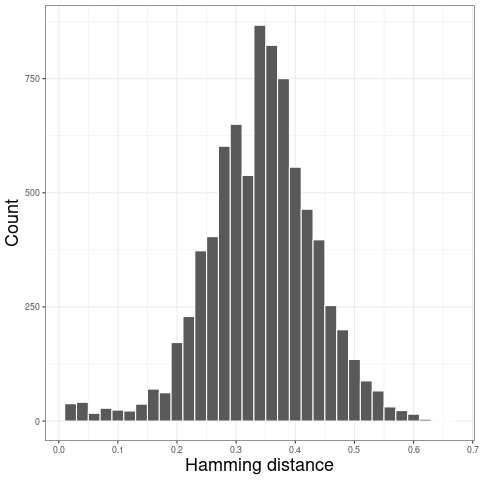

In [11]:
%%R
dist_nearest <- distToNearest(filter(data, locus == "IGH"), nproc = 1)

# generate Hamming distance histogram
p1 <- ggplot(subset(dist_nearest, !is.na(dist_nearest)),
             aes(x = dist_nearest)) + 
        theme_bw() + 
        xlab("Hamming distance") + ylab("Count") +
        scale_x_continuous(breaks = seq(0, 1, 0.1)) +
        geom_histogram(color = "white", binwidth = 0.02) + 
        theme(axis.title = element_text(size = 18))
plot(p1)

The resulting distribution is often bimodal, with the first mode representing sequences with clonal relatives in the dataset and the second mode representing singletons. We can inspect the plot of nearest-neighbor distance distribution generated above to manually select a threshold to separates the two modes of the nearest-neighbor distance distribution. 

For further details regarding inferring an appropriate threshold for the hierarchical clustering method, see the [Distance to Nearest Neighbor vignette](https://shazam.readthedocs.io/en/stable/vignettes/DistToNearest-Vignette/) in the shazam package.

### Find the distance threshold for cloning automatically

The threshold itself can be also found using the automatic `findThreshold` function. There are different ways to find the threshold and details can also be found in the [Distance to Nearest Neighbor vignette](https://shazam.readthedocs.io/en/stable/vignettes/DistToNearest-Vignette/) in the shazam package.

A robust way that we recommend is to use the nearest-neighbor distance of inter (between) clones as the background and select the threshold based on the specificity of this background distribution. 

In [12]:
%%R
# find threshold for cloning automatically
threshold_output <- findThreshold(dist_nearest$dist_nearest, 
                       method = "gmm", model = "gamma-norm", 
                       cutoff = "user", spc = 0.995)
threshold <- threshold_output@threshold
threshold

[1] 0.1305884


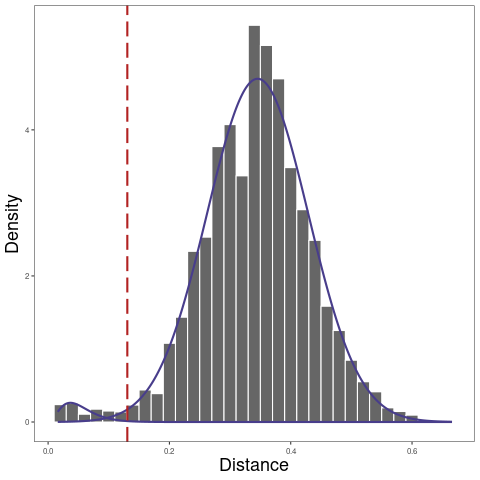

In [13]:
%%R
plot(threshold_output, binwidth = 0.02, silent = T) + 
  theme(axis.title = element_text(size = 18))

The nearest-neighbor distance distribution is not always bimodal. In this case, if the data have multiple subjects, we can calculate the nearest neighbor distances across subjects to initialize the Gaussian fit parameters of the nearest-neighbor distance of inter (between) clones distribution. 

The nearest neighbor distances across subjects can be calculated by specifying the parameter `cross` in the function `distToNearest`. And then when we call function `findThreshold`, Gaussian fit parameters can be initialized by setting parameter `cross = dist_crossSubj$cross_dist_nearest`.

In the example below, BCR data from donor 2 together with the BCR data from donor 1, was used to calculate the nearest neighbor distances across subjects:

In [14]:
%%R
# read in BCR data from donor 2 
data_10x_example <- readChangeoDb('../data/10x_data_2subj/sc5p_v2_hs_B_1k_multi_5gex_b_Multiplex_vdj_b_all_contig_igblast_db-pass.tsv')
data_10x_example$subject <- "Subj2"

cat(paste("There are", nrow(data_10x_example), "rows in the donor 2 data.\n"))

# label the donor 1 data
data$subject <- "Subj1"

# combine donors 1 and 2
data_both_subjects <- rbind(data, data_10x_example)
data_both_subjects %>% slice_sample(n = 5) # random examples

There are 7060 rows in the donor 2 data.
# A tibble: 5 × 58
  sequence_id sequence rev_comp productive v_call d_call j_call sequence_alignm…
  <chr>       <chr>    <lgl>    <lgl>      <chr>  <chr>  <chr>  <chr>           
1 CCGTACTGTT… CGAGCCC… FALSE    TRUE       IGHV3… IGHD2… IGHJ5… CAGGTGCAGCTGGTG…
2 CCTTCCCTCA… GGGAGCA… FALSE    TRUE       IGHV1… IGHD6… IGHJ4… CAGGTGCAGCTGGTG…
3 TTCGGTCGTC… AGCACAC… FALSE    TRUE       IGLV7… <NA>   IGLJ3… CAGGCTGTGGTGACT…
4 CGGACACAGA… TGGGGAC… FALSE    TRUE       IGKV2… <NA>   IGKJ2… GATATTGTGATGACT…
5 CACAGTACAG… ACGATTT… FALSE    TRUE       IGLV2… <NA>   IGLJ2… CAGTCTGCCCTGACT…
# … with 50 more variables: germline_alignment <chr>, junction <chr>,
#   junction_aa <chr>, v_cigar <chr>, d_cigar <chr>, j_cigar <chr>,
#   stop_codon <lgl>, vj_in_frame <lgl>, locus <chr>, junction_length <dbl>,
#   np1_length <dbl>, np2_length <dbl>, v_sequence_start <dbl>,
#   v_sequence_end <dbl>, v_germline_start <dbl>, v_germline_end <dbl>,
#   d_sequence_start <

In [15]:
%%R
# calculate cross subjects distribution of distance to nearest
dist_crossSubj <- distToNearest(filter(data_both_subjects, locus == "IGH"), 
                                nproc = 1, cross = "subject")

# find threshold for cloning automatically and initialize the Gaussian fit parameters of the nearest-neighbor 
# distance of inter (between) clones using cross subjects distribution of distance to nearest
threshold_output <- findThreshold(dist_nearest$dist_nearest, 
                                  method = "gmm", model = "gamma-norm", 
                                  cross = dist_crossSubj$cross_dist_nearest,
                                  cutoff = "user", spc = 0.995)
threshold <- threshold_output@threshold
threshold

[1] 0.1305855


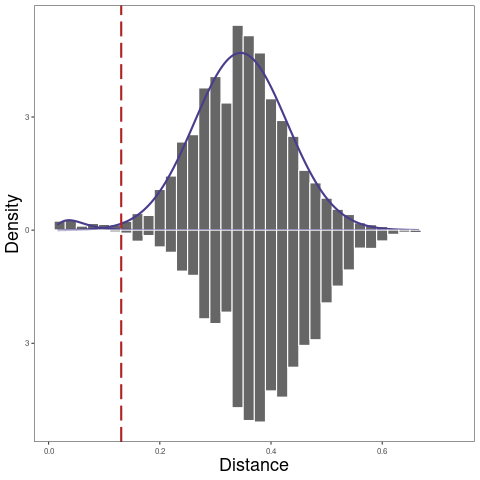

In [16]:
%%R
plot(threshold_output, binwidth = 0.02, 
     cross = dist_crossSubj$cross_dist_nearest, silent = T) + 
  theme(axis.title = element_text(size = 18))

In the plot above, the top plot is the nearest-neighbor distance distribution within Subj1, and the bottom plot is the nearest neighbor distances across Subj1 and Subj2.

## Define clonal groups

After we decide the threshold for calling clones, the `hierachicalClones` function in SCOPer package can be used to call clones using single cell mode:

In [17]:
%%R
# call clones using hierarchicalClones 
results <- hierarchicalClones(data, cell_id = 'cell_id', 
                              threshold = threshold, only_heavy = FALSE, 
                              split_light = TRUE, summarize_clones = FALSE)

R[write to console]: Running defineClonesScoper in single cell mode



`HierarchicalClones` clusters B receptor sequences based on junction region sequence similarity within partitions that share the same V gene, J gene, and junction length, thus allowing for ambiguous V or J gene annotations. By setting it up the `cell_id` parameter, `HierarchicalClones` will run in single-cell mode with paired-chain sequences. With `only_heavy = FALSE` and `split_light = TRUE`, grouping should be done by using IGH plus IGK/IGL sequences and inferred clones should be split by the light/short chain (IGK and IGL) following heavy/long chain clustering.

After calling clones, a clonal abundance distribution can be displayed:

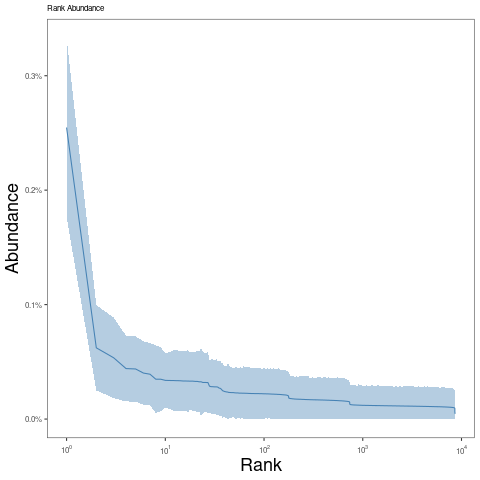

In [18]:
%%R
# calculate and plot the rank-abundance curve
plot(estimateAbundance(results), colors = "steelblue", silent = T) + 
  theme(axis.title = element_text(size = 18))

## Create Germlines

Before B cell lineage trees can be built, it is necessary to construct the unmutated germline sequence for each B cell clone. Typically the IGH D segment is masked because the junction region of heavy chains often cannot be reliably reconstructed. Note that occasionally errors are thrown for some clones - this is typical and usually results in those clones being excluded.

In the example below, we read in the IMGT germline references from our Docker container. If you're using a local installation, you can download the most up-to-date reference genome by cloning the Immcantation repository and running the script:

```bash
git clone https://bitbucket.org/kleinstein/immcantation.git
./immcantation/scripts/fetch_imgtdb.sh # will create directories where it is run
```

And passing `"human/vdj/"` to the `readIMGT` function.

In [19]:
%%R
# run createGermlines using IMGT files in Docker container.
references <- readIMGT(dir = "/usr/local/share/germlines/imgt/human/vdj")

h <- createGermlines(filter(results, locus == "IGH"), references)
k <- createGermlines(filter(results, locus == "IGK"), references, locus = "IGK")
l <- createGermlines(filter(results, locus == "IGL"), references, locus = "IGL")

[1] "Read in 1147 from 17 fasta files"
<simpleError in buildGermline(cons, references = sub_db, seq = seq, v_call = v_call,     j_call = j_call, j_germ_length = j_germ_length, amino_acid = amino_acid,     ...): Germline sequence differs from input sequence by -5 in clone 364>
<simpleError in buildGermline(cons, references = sub_db, seq = seq, v_call = v_call,     j_call = j_call, j_germ_length = j_germ_length, amino_acid = amino_acid,     ...): Germline sequence differs from input sequence by -5 in clone 7735>


## Calculate SHM frequency in the V gene

Basic mutational load calculations can be performed by the function `observedMutations` in the [SHazaM](https://shazam.readthedocs.io/en/stable/) R package:

In [20]:
%%R
# calculate SHM frequency in the V gene
data_h <- observedMutations(h, 
                            sequenceColumn = "sequence_alignment",
                            germlineColumn = "germline_alignment_d_mask",
                            regionDefinition = IMGT_V,
                            frequency = TRUE,
                            combine = TRUE, 
                            nproc = 1)

The plot below shows the distribution of median mutation frequency of clones:

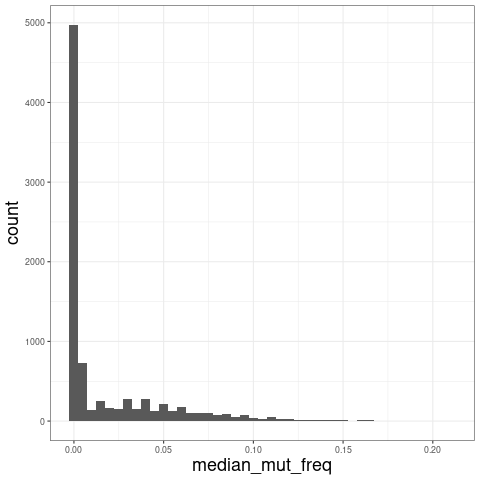

In [21]:
%%R
# calculate the median mutation frequency of a clone
mut_freq_clone <- data_h %>% 
                  group_by(clone_id) %>% 
                  summarise(median_mut_freq = mean(mu_freq))

ggplot(mut_freq_clone, aes(median_mut_freq)) + 
    geom_histogram(, binwidth = 0.005) + theme_bw() +
    theme(axis.title = element_text(size = 18))

## Format clones for tree building in Dowser

Before we can build lineage trees, our data must be formatted into a tibble of airrClone objects. 

* If we want to visualize information in a column on the tree, we must specify that column in the `traits` column.
  * To specify multiple traits, input a vector into this column. 
* If we want our clones tibble to have a column showing the subject each clone was obtained from, we can specify the `subject` column in the `columns` option. 
* By default, identical sequences will be collapsed unless they differ by the values in the `traits` column.
* `minseq` will remove all clones with fewer than the specified number of sequences.

In [22]:
%%R
clones <- formatClones(data_h, 
                       traits = "c_call", columns = "subject", 
                       minseq = 3)
print(clones)

# A tibble: 15 × 5
   clone_id data       locus  seqs subject
   <chr>    <list>     <chr> <int> <chr>  
 1 4499     <airrClon> IGH       5 Subj1  
 2 6578     <airrClon> IGH       5 Subj1  
 3 2387     <airrClon> IGH       4 Subj1  
 4 146      <airrClon> IGH       3 Subj1  
 5 1900     <airrClon> IGH       3 Subj1  
 6 2165     <airrClon> IGH       3 Subj1  
 7 2600     <airrClon> IGH       3 Subj1  
 8 3856     <airrClon> IGH       3 Subj1  
 9 4879     <airrClon> IGH       3 Subj1  
10 4976     <airrClon> IGH       3 Subj1  
11 5868     <airrClon> IGH       3 Subj1  
12 6379     <airrClon> IGH       3 Subj1  
13 7340     <airrClon> IGH       3 Subj1  
14 7875     <airrClon> IGH       3 Subj1  
15 8177     <airrClon> IGH       3 Subj1  


### Build trees using maximum likelihood

Dowser offers multiple ways to build lineage trees, including maximum parsimony, maximum likelihood, and B cell specific models such as IgPhyML.

Here, we build trees using the likelihood maximization functions from the `phangorn` package in R. The tree objects themselves are saved as R `phylo` objects in the `trees` column.

In [23]:
%%R
trees <- getTrees(clones, build = "pml", nproc = 1)
print(trees)

# A tibble: 15 × 6
   clone_id data       locus  seqs subject trees  
   <chr>    <list>     <chr> <int> <chr>   <list> 
 1 4499     <airrClon> IGH       5 Subj1   <phylo>
 2 6578     <airrClon> IGH       5 Subj1   <phylo>
 3 2387     <airrClon> IGH       4 Subj1   <phylo>
 4 146      <airrClon> IGH       3 Subj1   <phylo>
 5 1900     <airrClon> IGH       3 Subj1   <phylo>
 6 2165     <airrClon> IGH       3 Subj1   <phylo>
 7 2600     <airrClon> IGH       3 Subj1   <phylo>
 8 3856     <airrClon> IGH       3 Subj1   <phylo>
 9 4879     <airrClon> IGH       3 Subj1   <phylo>
10 4976     <airrClon> IGH       3 Subj1   <phylo>
11 5868     <airrClon> IGH       3 Subj1   <phylo>
12 6379     <airrClon> IGH       3 Subj1   <phylo>
13 7340     <airrClon> IGH       3 Subj1   <phylo>
14 7875     <airrClon> IGH       3 Subj1   <phylo>
15 8177     <airrClon> IGH       3 Subj1   <phylo>


### Build trees using IgPhyML

To build lineage trees using the B cell specific models in IgPhyML, you must specify the location of the compiled IgPhyML executable in your system. 

* Here, we use its location in the Docker image.
* The format of the output is the same regardless of the method used to build the tree.
* With IgPhyML, however, a column of `parameters` is also returned, which gives the parameter values of the HLP19 model.

In [24]:
%%R
trees <- getTrees(clones, 
                  build = "igphyml", nproc = 1, exec = "/usr/local/share/igphyml/src/igphyml")
print(trees)

# A tibble: 15 × 7
   clone_id data       locus  seqs subject parameters        trees       
   <chr>    <list>     <chr> <int> <chr>   <named list>      <named list>
 1 4499     <airrClon> IGH       5 Subj1   <named list [13]> <phylo>     
 2 6578     <airrClon> IGH       5 Subj1   <named list [13]> <phylo>     
 3 2387     <airrClon> IGH       4 Subj1   <named list [13]> <phylo>     
 4 146      <airrClon> IGH       3 Subj1   <named list [13]> <phylo>     
 5 1900     <airrClon> IGH       3 Subj1   <named list [13]> <phylo>     
 6 2165     <airrClon> IGH       3 Subj1   <named list [13]> <phylo>     
 7 2600     <airrClon> IGH       3 Subj1   <named list [13]> <phylo>     
 8 3856     <airrClon> IGH       3 Subj1   <named list [13]> <phylo>     
 9 4879     <airrClon> IGH       3 Subj1   <named list [13]> <phylo>     
10 4976     <airrClon> IGH       3 Subj1   <named list [13]> <phylo>     
11 5868     <airrClon> IGH       3 Subj1   <named list [13]> <phylo>     
12 6379     <airrCl

### Visualize trees with constant region on tips

Regardless of how you build trees, they are visualized in the same manner with the `plotTrees` function. This will return a list of `ggplot` objects in the same order as the input object. Here, we color the tips by the `c_call` value because we specified that column in the `formatClones` step.

In [25]:
%%R
p <- plotTrees(trees, tips = "c_call", tipsize = 4)

# plot first tree
p[[1]]

# save all trees to a pdf
treesToPDF(p, file = "results/alltrees.pdf")

png 
  2 


### Reconstruct intermediate sequences

Sequences of intermediate nodes are automatically reconstructed during the tree build process. To retrieve them, first plot the node numbers for each node. The function `collapseNodes` can help clean up the tree plots. 

Then, use the `getNodeSeq` function to retrieve the sequence at the desired node.

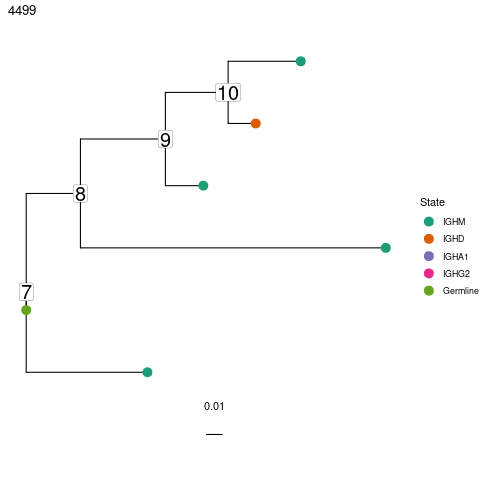

In [26]:
%%R
trees <- collapseNodes(trees)

# plot trees with node ID numbers
p <- plotTrees(trees, tips = "c_call", tipsize = 4, 
               node_nums = TRUE, labelsize = 7)
p[[1]]

In [27]:
%%R
# get the sequence at node 8
first_clone_id <- trees[["clone_id"]][1]
sequence <- getNodeSeq(trees, clone = first_clone_id, node = 8)
print(sequence)

                                                                                                                                                                                                                                                                                                                                                                                                     IGH 
"GAGGTGCAGCTGGTGGAGTCTGGGGGA...GGCTTGGTAAAGCCTGGGGGGTCCCTTAGACTCTCCTGTGCAGCCTCTGGATTCACTTTC............AGTAACGCCTGGATGARCTGGGTCCGCCAGGCTCCAGGGAAGGGGCTGGAGTGGGTTGGCCGTATTAAAAGCAAAACTGATGGTGGGACAACAGACTACGCTGCACCCGTGAAA...GGCAGATTCACCATCTCAAGAGATGATTCAAAAAACACGYTGTATCTRCAAATGAACAGCCTGAAAACCGACGACACAGCCGTGTATTACTGTGCCACCCGCCCGCCACCATTCGGTGACTACHCCCTTGACTACTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAGNN" 


### Analyzing B cell migration, differentiation, and evolution over time

In addition to the functions for building and visualizing trees, Dowser also implements new techniques for analyzing B cell migration and differentiation, as well as for detecting new B cell evolution over time. These are more advanced topics detailed on the [Dowser site](https://dowser.readthedocs.io).

If you have data from different **tissues, B cell subtypes, and/or isotypes** and want to use lineage trees to study the pattern of those traits along lineage trees, check out the [discrete trait vignette](https://dowser.readthedocs.io/en/latest/vignettes/Discrete-Trait-Vignette/).

If you have data from **multiple timepoints** from the same subject and want to determine if B cell lineages are evolving over the sampled interval, check out the [measurable evolution vignette](https://dowser.readthedocs.io/en/latest/vignettes/Measurable-Evolution/).

For more advanced tree **visualization**, check out the [plotting trees vignette](https://dowser.readthedocs.io/en/latest/vignettes/Plotting-Trees-Vignette/).